In [10]:
# Import necessary libraries
import numpy as np
import pandas as pd
import re
from collections import Counter

In [11]:
# read text File 
with open("english_big (2).txt") as f:
    data = f.readlines()

#convert to Df 
text = []
lebal = []
for line in data:
    tmp = line.split(",")
    text.append(tmp[0])
    lebal.append(tmp[-1].replace('\n',''))

Df = pd.DataFrame({"Label":lebal,"Text":text})
Df

,Label,Text
0,spam,Urgent! call 09061749602 from Landline. Your c...
1,spam,+449071512431 URGENT! This is the 2nd attempt ...
2,spam,FREE for 1st week! No1 Nokia tone 4 ur mob eve...
3,spam,Urgent! call 09066612661 from landline. Your c...
4,spam,WINNER!! As a valued network customer you have...
...,...,...
1319,spam,Great News! Call FREEFONE 08006344447 to claim...
1320,spam,You have WON a guaranteed £1000 cash or a £200...
1321,spam,08714712388 between 10am-7pm Cost 10p
1322,spam,YES! The only place in town to meet exciting a...


In [12]:
# Print the unique values in the 'Label' column
print(Df['Label'].unique())
# Create a new 'Target' column in the DataFrame where 'spam' is mapped to 1 and other labels to 0
Df['Target'] = Df['Label'].apply(lambda x: 1 if x == 'spam' else 0)

['spam' 'ham']


In [13]:
Word_Freq_Dict = {}
# Iterate through each row in the DataFrame and count the frequency of words in the 'Text' column

for index,row in Df.iterrows():
    for word in row['Text'].split(' '):
        wd = word.lower()
        if wd in Word_Freq_Dict:
            Word_Freq_Dict[wd] +=1
        else:
            Word_Freq_Dict[wd] =1


# Clean the Word_Freq_Dict by setting word frequencies for specific words and letters to 0
# The purpose of this cleaning is related to feature extraction
for letter in range(ord('a'), ord('z') + 1):
    Word_Freq_Dict[chr(letter)] = 0
for word in ['the','an','in','to','is','for','he','she','its','have','and','of','are','it','will','do','but','','with']:
    Word_Freq_Dict[word] = 0

In [14]:
# Define a function to extract text features such as the number of characters, currency symbols, numeric strings,
def extract_text_features(text):
    # Number of Characters typed in Message
    num_characters = len(text)

    # Number of Currency Symbols (e.g., $)
    currency_symbols = re.findall(r'[$€¥£¢₹₽₱₸₺₿₡₵₴₣₩]', text)
    num_currency_symbols = len(currency_symbols)

    # Number of Numeric Strings
    num_numeric_strings = len(re.findall(r'\d+', text))

    # Tokenize the text and calculate the frequency of terms/words
    most_popular_term, most_popular_term_frequency = '-',0

    # Tokenize the text and calculate the frequency of terms/words
    words = re.findall(r'\b\w+\b', text.lower())  # Tokenize text into words
    if not words:
        most_popular_term = "No words found"
        most_popular_term_frequency = 0
    else:
        word_frequency = Counter(words)  # Count word frequencies
        most_popular_term, most_popular_term_frequency = word_frequency.most_common(1)[0]

    return num_characters, num_currency_symbols, num_numeric_strings, most_popular_term, most_popular_term_frequency

In [15]:
# Apply the 'extract_text_features' function to the 'Text' column and create new columns with the extracted features
Df[['Num_Characters', 'Num_Currency_Symbols', 'Num_Numeric_Strings', 'Most_Popular_Term', 'Most_Popular_Term_Frequency']] = Df['Text'].apply(extract_text_features).apply(pd.Series)

# Define the input features (X) and target variable (Y)
X = Df[['Num_Characters', 'Num_Currency_Symbols', 'Num_Numeric_Strings', 'Most_Popular_Term_Frequency']]
Y = Df[['Target']]

In [16]:
# Import necessary libraries for model evaluation and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix

In [17]:
# Define a function to evaluate a machine learning model, including plotting confusion matrices and cross-validation scores

def evaluate_model(model, X, y, test_size=0.2):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Fit the model on the training data
    model.fit(X_train, y_train.values.ravel())
    
    # Generate confusion matrix on the testing data
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    scores = cross_val_score(model, X, y.values.ravel(), cv=10, scoring='accuracy')
    # print(f'Cross-Validation Scores: { scores}')
    # print(f'Mean Accuracy: {np.mean(scores):.2f}')
    
    # Plot confusion matrix and cross-validation scores
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.subplot(1, 2, 2)
    plt.plot(range(1, 10 + 1), scores, marker='o', linestyle='-')
    plt.title('Cross-Validation Scores')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()
    
    # Calculate True Positive Rate (TPR), False Positive Rate (FPR), and Mean Accuracy
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    Accuracy = np.mean(scores)
    return Accuracy, TPR, FPR


#### Import machine learning models and evaluate their performance using the defined function
### In this code, Decision Tree, Naive Bayes, K-Nearest Neighbors, Support Vector Classifier, and Random Forest models are evaluated

## 1. Decision Tree (J48)

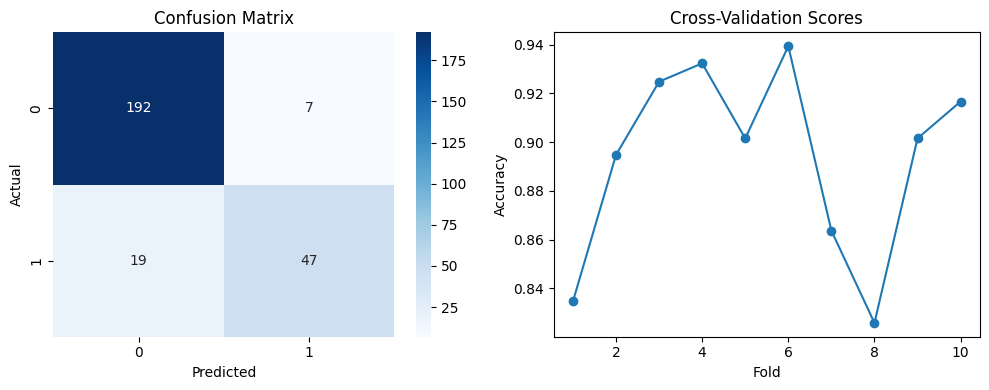

Mean Accuracy : 89.35 %
True Positive Rate (TPR): 71.21 %
False Positive Rate (FPR): 3.52 %


In [18]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
Accuracy,TPR,FPR = evaluate_model(dt_model, X, Y)

print("Mean Accuracy :", round(Accuracy*100,2),"%")
print("True Positive Rate (TPR):", round(TPR*100,2),"%")
print("False Positive Rate (FPR):", round(FPR*100,2),"%")

## 2. Multinomial Naive Bayes

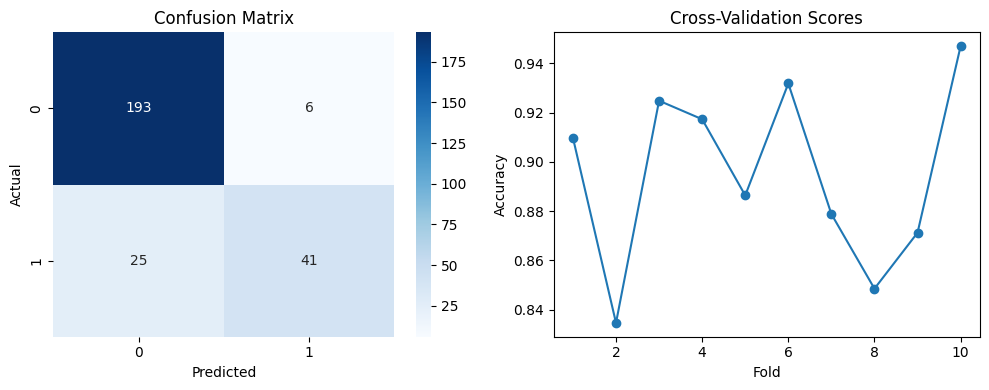

Mean Accuracy : 89.5 %
True Positive Rate (TPR): 62.12 %
False Positive Rate (FPR): 3.02 %


In [19]:
from sklearn.naive_bayes import MultinomialNB
dt_model = MultinomialNB()
Accuracy,TPR,FPR = evaluate_model(dt_model, X, Y)

print("Mean Accuracy :", round(Accuracy*100,2),"%")
print("True Positive Rate (TPR):", round(TPR*100,2),"%")
print("False Positive Rate (FPR):", round(FPR*100,2),"%")

## 3. K-Nearest Neighbors

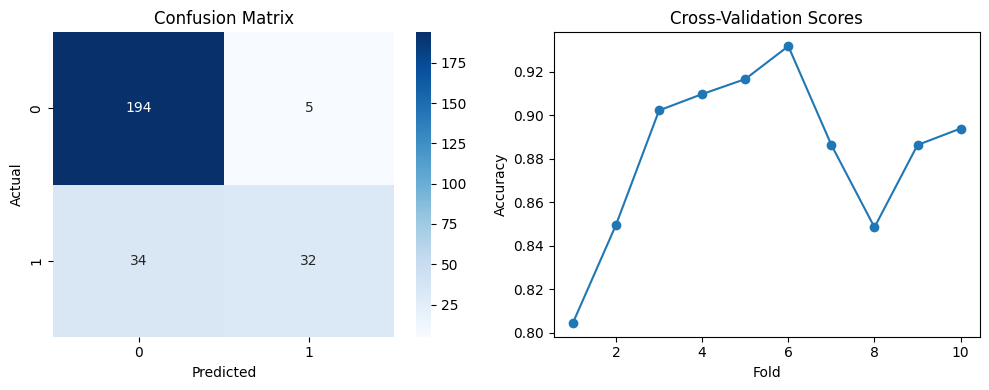

Mean Accuracy : 88.3 %
True Positive Rate (TPR): 48.48 %
False Positive Rate (FPR): 2.51 %


In [20]:
from sklearn.neighbors import KNeighborsClassifier
dt_model = KNeighborsClassifier()
Accuracy,TPR,FPR = evaluate_model(dt_model, X, Y)

print("Mean Accuracy :", round(Accuracy*100,2),"%")
print("True Positive Rate (TPR):", round(TPR*100,2),"%")
print("False Positive Rate (FPR):", round(FPR*100,2),"%")

## 4. SVM (LibSVM)

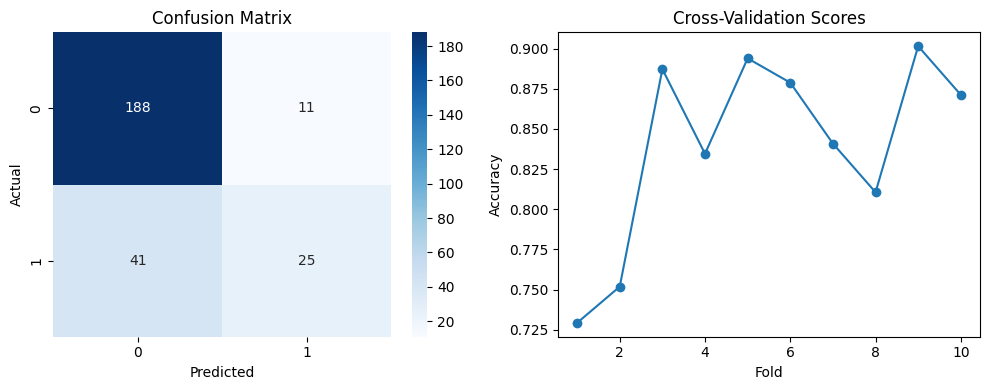

Mean Accuracy : 84.0 %
True Positive Rate (TPR): 37.88 %
False Positive Rate (FPR): 5.53 %


In [21]:
from sklearn.svm import SVC
dt_model = SVC()
Accuracy,TPR,FPR = evaluate_model(dt_model, X, Y)

print("Mean Accuracy :", round(Accuracy*100,2),"%")
print("True Positive Rate (TPR):", round(TPR*100,2),"%")
print("False Positive Rate (FPR):", round(FPR*100,2),"%")

## 5. RandomForest

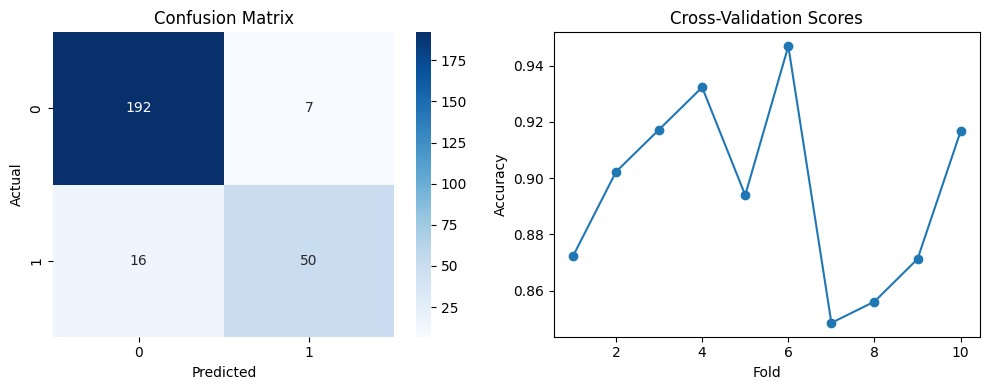

Mean Accuracy : 89.57 %
True Positive Rate (TPR): 75.76 %
False Positive Rate (FPR): 3.52 %


In [22]:
from sklearn.ensemble import RandomForestClassifier
dt_model = RandomForestClassifier()
Accuracy,TPR,FPR = evaluate_model(dt_model, X, Y)

print("Mean Accuracy :", round(Accuracy*100,2),"%")
print("True Positive Rate (TPR):", round(TPR*100,2),"%")
print("False Positive Rate (FPR):", round(FPR*100,2),"%")